In [68]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

In [72]:
covid_df = pd.read_excel("Balanced_Data_Set.xlsx")
covid_df.shape

(600, 21)

In [73]:
covid_cols = [ 'Hematocrit', 'Hemoglobin',
        'Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes',
        'Basophils', 'Eosinophils', 'Monocytes', 'Serum Glucose', 'Neutrophils',
      'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium',
       'Alanine transaminase', 'Aspartate transaminase','Label']

#covid_df = covid_df[covid_cols]
# print(covid_df)



clinicalOutput = covid_df["Label"]
clinicalInput = covid_df.drop(["Patient ID","Patient age quantile"],axis=1)
# print(clinicalOutput)
# print(clinicalInput)
clinicalInput.shape

(600, 19)

In [74]:
models = [
    ExtraTreesClassifier(n_estimators=300, max_depth=15),
     
    RandomForestClassifier(n_estimators=90, max_depth=19),
   GradientBoostingClassifier(learning_rate=0.1, n_estimators=290,max_depth=11, min_samples_leaf =30, 
               min_samples_split =100, max_features=11, random_state=10,subsample=0.85),
   
#     LogisticRegression(solver = 'saga', max_iter= 600, multi_class='ovr',
#                         class_weight='balanced'),
    XGBClassifier(learning_rate=0.4, n_estimators=50, max_depth=17,  eval_metric='error')
#     XGBClassifier(learning_rate=1.0,
#                           n_estimators=30, max_depth=17)
]            

In [87]:
#configure bootstrap
n_iterations = 1

accuracies_stats  = list()
AUC_stats         = list()
pre_stats         = list()
recall_stats      = list()
f1_stats          = list()
sensitivity_stats = list()
specificity_stats = list()
TP_list = list()
TN_list = list()
FP_list = list()
FN_list = list()

for i in range(n_iterations):

#     imputer = KNNImputer(n_neighbors=7)
#     Ximputer = imputer.fit_transform(clinicalInput)
    dataframe=pd.DataFrame(clinicalInput, columns=covid_cols)

    outlier_detect = IsolationForest(n_estimators=150, max_samples=600, contamination=float(0.02), max_features=clinicalInput.shape[1])

    dataframe = dataframe.values
    outlier_detect.fit(dataframe)


    outliers_predicted = outlier_detect.predict(dataframe)
    covid_check = dataframe[outlier_detect.predict(dataframe) == -1]
    dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

     #values = dataframe.values
    n_size = int(len(dataframe) * 0.80)

    # prepare train and test sets
    #data_sample = resample(values, n_samples=n_size)
    data_sample = resample(dataframe, n_samples=n_size)


    dataframe = pd.DataFrame(data_sample, columns=covid_cols)
#    print(dataframe)
    
    # split into input and output elements
    y = dataframe.Label # Target variable
    X = dataframe.drop(['Label'], axis = 1) # Features

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    sm = SMOTE(k_neighbors=11)
    x_res, y_res = sm.fit_resample(X_train, y_train)
    
#     XGBRegressor_bagging_model = BaggingRegressor(models,
#                                               n_estimators=100,                                              
#                                               max_samples=1.0, 
#                                               max_features=1.0, 
#                                               bootstrap=True,
#                                               oob_score=True, 
#                                               warm_start=False,
#                                               n_jobs=-1,
#                                               verbose=0)
    

    S_train, S_test = stacking(models,
                               x_res, y_res, X_test,
                               regression=False,

                               mode='oof_pred',

                               needs_proba=False,

                               save_dir=None,

                               metric=metrics.accuracy_score,

                               n_folds=10,

                               stratified=True,

                               shuffle=True,

                               verbose=2)

#     model = XGBClassifier(learning_rate=1.0,
#                           n_estimators=300, max_depth=17)



#     model = LogisticRegression(solver = 'saga', max_iter= 10, multi_class='ovr',
#                         class_weight='balanced')
    
    
    
    from sklearn.svm import SVC
    model = SVC(probability=True)   
    

    # fit model
    model = model.fit(S_train, y_res)

	# evaluate model
    y_pred = model.predict(S_test)
    score = metrics.accuracy_score(y_test, y_pred)

    accuracies_stats.append(score)

    probs = model.predict_proba(S_test)
    probs = probs[:, 1]
    AUC_stats.append(metrics.roc_auc_score(y_test, probs))

    pre_stats.append(metrics.precision_score(y_test, y_pred, average='binary'))
    recall_stats.append(metrics.recall_score(y_test, y_pred, average='binary'))
    f1_stats.append(metrics.f1_score(y_test, y_pred, average='binary'))

    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # recall of the positive
    sensitivity = TP / float(FN + TP)

    # recall of the negative class
    specificity = TN / (TN + FP)

    sensitivity_stats.append(sensitivity)
    specificity_stats.append(specificity)

    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred]
n_models:     [4]

model  0:     [ExtraTreesClassifier]
    fold  0:  [0.98484848]
    fold  1:  [0.98484848]
    fold  2:  [0.93939394]
    fold  3:  [0.96969697]
    fold  4:  [0.98484848]
    fold  5:  [0.96969697]
    fold  6:  [1.00000000]
    fold  7:  [1.00000000]
    fold  8:  [1.00000000]
    fold  9:  [0.98461538]
    ----
    MEAN:     [0.98179487] + [0.01766569]
    FULL:     [0.98170732]

    Fitting on full train set...

model  1:     [RandomForestClassifier]
    fold  0:  [0.96969697]
    fold  1:  [0.98484848]
    fold  2:  [0.95454545]
    fold  3:  [0.95454545]
    fold  4:  [0.96969697]
    fold  5:  [0.96969697]
    fold  6:  [0.98461538]
    fold  7:  [1.00000000]
    fold  8:  [0.98461538]
    fold  9:  [0.98461538]
    ----
    MEAN:     [0.97568765] + [0.01384115]
    FULL:     [0.97560976]

    Fitting on full train set...

model  2:     [GradientBoostingCla

In [88]:
print("Average TP  = {}".format(np.round(np.array(TP_list).mean(), 4)))
print("Average TN  = {}".format(np.round(np.array(TN_list).mean(), 4)))
print("Average FP  = {}".format(np.round(np.array(FP_list).mean(), 4)))
print("Average FN  = {}".format(np.round(np.array(FN_list).mean(), 4)))

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(accuracies_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracies_stats, p))

print("Average accuracy  = {}".format(np.round(np.array(accuracies_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(AUC_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(AUC_stats, p))

print("Average AUC       = {}".format(np.round(np.array(AUC_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(pre_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(pre_stats, p))
print("Average precision = {}".format(np.round(np.array(pre_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(recall_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(recall_stats, p))
print("Average recall    = {}".format(np.round(np.array(recall_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f1_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f1_stats, p))
print("Average f1 score = {}".format(np.round(np.array(f1_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(sensitivity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(sensitivity_stats, p))
print("Sensitivity score = {}".format(np.round(np.array(sensitivity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(specificity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(specificity_stats, p))
print("Specificity score = {}".format(np.round(np.array(specificity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


Average TP  = 6.0
Average TN  = 87.0
Average FP  = 0.0
Average FN  = 1.0
Average accuracy  = 0.9894
95.0 confidence interval 98.9% and 98.9%
Average AUC       = 0.9228
95.0 confidence interval 92.3% and 92.3%
Average precision = 1.0
95.0 confidence interval 100.0% and 100.0%
Average recall    = 0.8571
95.0 confidence interval 85.7% and 85.7%
Average f1 score = 0.9231
95.0 confidence interval 92.3% and 92.3%
Sensitivity score = 0.8571
95.0 confidence interval 85.7% and 85.7%
Specificity score = 1.0
95.0 confidence interval 100.0% and 100.0%


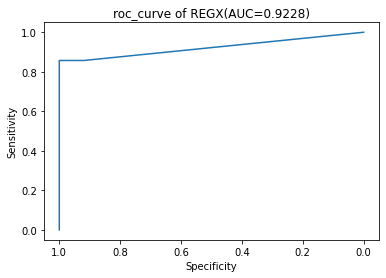

In [89]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_test, probs)  # 计算auc
fpr, tpr, threasholds = roc_curve(y_test, probs)  # 计算ROC的值
plt.title("roc_curve of %s(AUC=%.4f)" % ('REGX', auc))
plt.xlabel('Specificity')  # specificity = 1 - np.array(gbm_fpr))
plt.ylabel('Sensitivity')  # sensitivity = gbm_tpr
plt.plot(list(1 - np.array(fpr)), tpr)
plt.gca().invert_xaxis()  # 将X轴反转

# 保存图片并指定分辨率
dpi = 300  # 设置分辨率为300
save_path = "roc_curve.png"  # 保存路径及文件名
plt.savefig(save_path, dpi=dpi)

# 显示图片
plt.show()